# Exploratory data analysis on FBref shots

This notebook performs an exploratory data analysis on shots and xG values scraped from FBref to support the hypotheses in the paper.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns

Configure the soccerdata package.

In [2]:
%env SOCCERDATA_LOGLEVEL=ERROR
#%env SOCCERDATA_NOCACHE=True
#%env SOCCERDATA_NOSTORE=True
%env SOCCERDATA_DIR=/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccerdata

env: SOCCERDATA_LOGLEVEL=ERROR
env: SOCCERDATA_DIR=/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccerdata


Configure data and output folders.

In [3]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR = Path("images")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## Load dataset

In [4]:
# Select seasons and leagues to include in the analysis
leagues = ["ENG-Premier League", "ESP-La Liga", "FRA-Ligue 1", "GER-Bundesliga", "ITA-Serie A"]
seasons = ["2017-2018", "2018-2019", "2019-2020", "2020-2021", "2021-2022"]

In [5]:
# Load data from CSV file or scrape the data
fp_fbref_shots = DATA_DIR / "fbref_shots.csv"
if fp_fbref_shots.exists():
    df_shots_fbref = pd.read_csv(fp_fbref_shots)
    df_shots_fbref = df_shots_fbref.loc[~df_shots_fbref.league.isna()]
    df_shots_fbref["season"] = df_shots_fbref["season"].astype(int).astype(str)
    df_shots_fbref = df_shots_fbref.set_index(["league", "season", "game", "team", "player"])
else:
    import soccerdata as sd
    
    fbref = sd.FBref(leagues, seasons)
    df_shots_fbref = fbref.read_shot_events()
    df_shots_fbref.reset_index().to_csv(fp_fbref_shots, index=False)
df_shots_fbref['goal'] = df_shots_fbref["outcome"] == "Goal"
df_shots_fbref['delta'] = df_shots_fbref["goal"] - df_shots_fbref["xG"]
df_shots_fbref.head()

minute  \
league             season game                              team    player                           
ENG-Premier League 1718   2017-08-11 Arsenal-Leicester City Arsenal Aaron Ramsey                68   
                                                                    Aaron Ramsey                81   
                                                                    Aaron Ramsey                83   
                                                                    Aaron Ramsey              90+5   
                                                                    Alex Oxlade-Chamberlain      8   

                                                                                               xG  \
league             season game                              team    player                          
ENG-Premier League 1718   2017-08-11 Arsenal-Leicester City Arsenal Aaron Ramsey             0.29   
                                                                    Aaron Ramsey             0.03   
                                                                    Aaron Ramsey             0.07   
                                                                    Aaron Ramsey             0.03   
                                                                    Alex Oxlade-Chamberlain  0.04   

                                                                                             PSxG  \
league             season game                              team    player                          
ENG-Premier League 1718   2017-08-11 Arsenal-Leicester City Arsenal Aaron Ramsey              NaN   
                                                                    Aaron Ramsey              NaN   
                                                                    Aaron Ramsey             0.25   
                                                                    Aaron Ramsey              NaN   
                                                                    Alex Oxlade-Chamberlain   NaN   

                                                                                                outcome  \
league             season game                              team    player                                
ENG-Premier League 1718   2017-08-11 Arsenal-Leicester City Arsenal Aaron Ramsey             Off Target   
                                                                    Aaron Ramsey             Off Target   
                                                                    Aaron Ramsey                   Goal   
                                                                    Aaron Ramsey             Off Target   
                                                                    Alex Oxlade-Chamberlain  Off Target   

                                                                                             distance  \
league             season game                              team    player                              
ENG-Premier League 1718   2017-08-11 Arsenal-Leicester City Arsenal Aaron Ramsey                  9.0   
                                                                    Aaron Ramsey                  9.0   
                                                                    Aaron Ramsey                  8.0   
                                                                    Aaron Ramsey                 29.0   
                                                                    Alex Oxlade-Chamberlain      24.0   

                                                                                              body_part  \
league             season game                              team    player                                
ENG-Premier League 1718   2017-08-11 Arsenal-Leicester City Arsenal Aaron Ramsey                   Head   
                                                                    Aaron Ramsey                   Head   
                                               

## Distribution of xG values

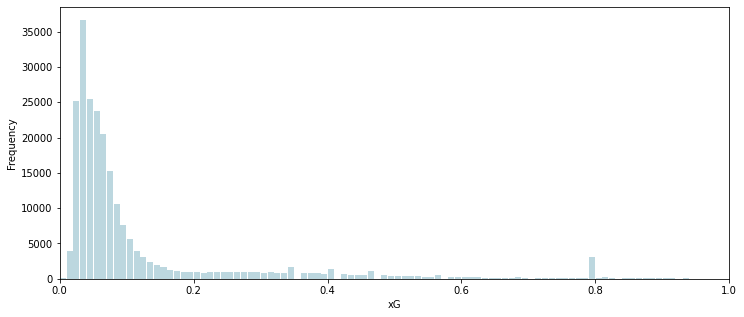

In [6]:
fig, ax = plt.subplots(figsize=(12,5))
binwidth = 0.01
ax.hist(df_shots_fbref.xG, bins=np.arange(0, 1 + binwidth, binwidth), density=False, rwidth=0.9, color="#bcd7df")
ax.set_xlabel("xG")
ax.set_ylabel("Frequency")
ax.set_xlim((0, 1))
plt.savefig(OUTPUT_DIR / "xg-distribution.pdf", transparent=True)
plt.show()

## Prolific shooters

In [7]:
df_shots_fbref.groupby("player").size().sort_values(ascending=False).head(n=20)

player
Cristiano Ronaldo     808
Lionel Messi          792
Robert Lewandowski    677
Mohamed Salah         658
Lorenzo Insigne       627
Harry Kane            620
Ciro Immobile         570
Edin Džeko            561
Domenico Berardi      532
Kylian Mbappé         532
Karim Benzema         520
Fabio Quagliarella    467
Andy Delort           465
Luis Suárez           458
Andrea Belotti        456
Federico Chiesa       449
Timo Werner           443
Nabil Fekir           438
Duván Zapata          437
Hakan Çalhanoğlu      432
dtype: int64

In [8]:
df_shots_fbref['count'] = 1
df = df_shots_fbref.groupby("player").agg({'delta': 'mean', 'count':'sum'})
df[df['count'] > 200].sort_values(ascending=False, by="delta").head(n=10)#.index.values

,delta,count
player,,
Son Heung-min,0.059267,382
Nils Petersen,0.056569,204
Riyad Mahrez,0.050511,313
Luis Muriel,0.049180,317
Dries Mertens,0.048052,385
Iago Aspas,0.046547,362
Martin Terrier,0.045830,235
Ruslan Malinovskyi,0.045721,201
James Ward-Prowse,0.045149,202


In [9]:
season_keys = ['1718', '1819', '1920', '2021', '2122']
df_delta_corr = []
for i in range(1, len(season_keys)):
    prev_season = df_shots_fbref.xs(season_keys[i-1], level="season").groupby(["team", "player"]).agg({'delta': 'mean', 'count':'sum'})
    curr_season = df_shots_fbref.xs(season_keys[i], level="season").groupby(["team", "player"]).agg({'delta': 'mean', 'count':'sum'})
    join = pd.merge(prev_season, curr_season, how="inner", suffixes=("_prev", "_curr"), left_index=True, right_index=True)
    df_delta_corr.append(join)
df_delta_corr = pd.concat(df_delta_corr)
df_delta_corr.head()

delta_prev  count_prev  delta_curr  count_curr
team   player                                                           
Alavés Burgui               0.020000          15    0.030000           8
       Carlos Vigaray      -0.070000           4   -0.020000           1
       Guillermo Maripán   -0.130000           4   -0.038000          15
       Ibai Gómez           0.038868          53    0.010732          41
       Ibai Gómez (pen)     0.210000           1   -0.790000           1

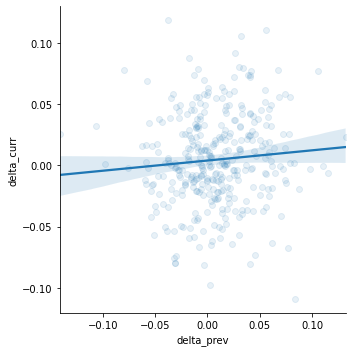

In [10]:
sns.lmplot(
    data=df_delta_corr[(df_delta_corr.count_prev > 50) & (df_delta_corr.count_curr > 50)], 
    x="delta_prev", 
    y="delta_curr", 
    scatter_kws={'alpha':0.1}
)
plt.savefig(OUTPUT_DIR / "delta-repeatability.pdf", transparent=True)


In [11]:
from sklearn.metrics import r2_score

df = df_delta_corr[(df_delta_corr.count_prev > 30) & (df_delta_corr.count_curr > 30)]
r2_score(df["delta_prev"], df["delta_curr"])

-0.8927918297158859

## Shots per season

In [12]:
shots_per_season = df_shots_fbref.groupby(["player", "season"]).size()
shots_per_season.sort_values(ascending=False)

player             season
Cristiano Ronaldo  1920      195
Lionel Messi       1718      193
                   2021      191
Harry Kane         1718      181
Lorenzo Insigne    1718      176
                            ... 
Nieto              2021        1
Gareth Bale (pen)  1819        1
                   1718        1
Nigel de Jong      1718        1
Tony Jantschke     2122        1
Length: 12129, dtype: int64

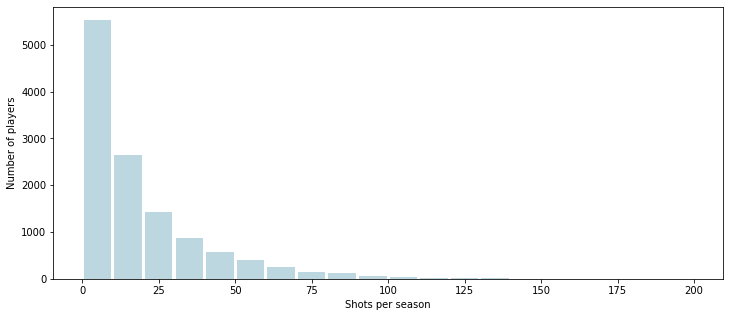

In [13]:
fig, ax = plt.subplots(figsize=(12,5))
binwidth = 0.01
ax.hist(shots_per_season, bins=np.arange(0, 201, 10), density=False, rwidth=0.9, color="#bcd7df")
ax.set_xlabel("Shots per season")
ax.set_ylabel("Number of players")
plt.savefig(OUTPUT_DIR / "shots-per-player-dist.pdf", transparent=True)
plt.show()

/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-xmskill/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


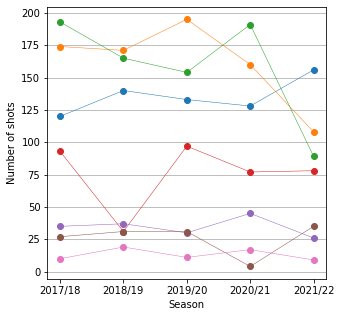

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
binwidth = 0.01
ax.plot(shots_per_season.loc["Robert Lewandowski"], '-o', lw=.5)
ax.plot(shots_per_season.loc["Cristiano Ronaldo"], '-o', lw=.5)
ax.plot(shots_per_season.loc["Lionel Messi"], '-o', lw=.5)
ax.plot(shots_per_season.loc["Kevin De Bruyne"], '-o', lw=.5)
ax.plot(shots_per_season.loc["Luka Modrić"], '-o', lw=.5)
ax.plot(shots_per_season.loc["Virgil van Dijk"], '-o', lw=.5)
ax.plot(shots_per_season.loc["Raphaël Varane"], '-o', lw=.5)
ax.grid(axis='y')

ax.set_xticklabels(["2017/18", "2018/19", "2019/20", "2020/21", "2021/22"])
ax.set_xlabel("Season")
ax.set_ylabel("Number of shots")
plt.savefig(OUTPUT_DIR / "shots-per-player.pdf", transparent=True)
plt.show()

/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-xmskill/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


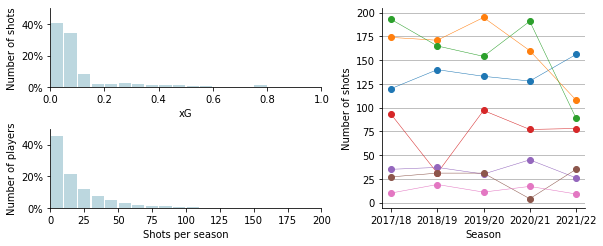

In [15]:
from matplotlib.ticker import PercentFormatter

gs_kw = dict(width_ratios=[2, 1.5], height_ratios=[1, 1])
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                              gridspec_kw=gs_kw, 
                              figsize=(8.5, 3.5))

# xg dist
binwidth = 0.05
axd['upper left'].hist(df_shots_fbref.xG, bins=np.arange(0, 1 + binwidth, binwidth), density=False, rwidth=0.9, color="#bcd7df", weights=np.ones(len(df_shots_fbref)) / len(df_shots_fbref))
axd['upper left'].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axd['upper left'].set_xlabel("xG")
axd['upper left'].set_ylabel("Number of shots")
axd['upper left'].set_xlim((0, 1))
axd['upper left'].set_ylim((0, .5))

# shot volume
axd['lower left'].hist(shots_per_season, bins=np.arange(0, 201, 10), density=False, rwidth=0.9, color="#bcd7df", weights=np.ones(len(shots_per_season)) / len(shots_per_season))
axd['lower left'].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axd['lower left'].set_xlabel("Shots per season")
axd['lower left'].set_ylabel("Number of players")
axd['lower left'].set_xlim((0, 200))
axd['lower left'].set_ylim((0, .5))


# players
axd['right'].plot(shots_per_season.loc["Robert Lewandowski"], '-o', lw=.5)
axd['right'].plot(shots_per_season.loc["Cristiano Ronaldo"], '-o', lw=.5)
axd['right'].plot(shots_per_season.loc["Lionel Messi"], '-o', lw=.5)
axd['right'].plot(shots_per_season.loc["Kevin De Bruyne"], '-o', lw=.5)
axd['right'].plot(shots_per_season.loc["Luka Modrić"], '-o', lw=.5)
axd['right'].plot(shots_per_season.loc["Virgil van Dijk"], '-o', lw=.5)
axd['right'].plot(shots_per_season.loc["Raphaël Varane"], '-o', lw=.5)
axd['right'].grid(axis='y')

axd['right'].set_xticklabels(["2017/18", "2018/19", "2019/20", "2020/21", "2021/22"])
axd['right'].set_xlabel("Season")
axd['right'].set_ylabel("Number of shots")

sns.despine()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "shots-xg-distribution.pdf", transparent=True)


## Number of deflected shots

In [16]:
df_shots_fbref['deflected'] = df_shots_fbref.notes.astype(str).apply(lambda x: 'Deflected' in x)
df_shots_fbref['deflected'].value_counts(normalize=True)#.plot(kind='barh')

False    0.976869
True     0.023131
Name: deflected, dtype: float64

## Performance on specific shot types

In [17]:
df_shots_fbref["long_distance"] = df_shots_fbref["distance"] > 16.5

In [18]:
# Absolute counts of shots grouped by body part and distance
df_shots_fbref.groupby(["body_part", "long_distance"]).size()

body_part   long_distance
Head        False            38181
            True               833
Left Foot   False            30589
            True             41155
Other       False              896
            True                10
Right Foot  False            46260
            True             67269
dtype: int64

In [19]:
# Relative counts of shots grouped by body part and distance
(df_shots_fbref.groupby(["body_part", "long_distance"]).size() / len(df_shots_fbref)).sort_values()

body_part   long_distance
Other       True             0.000044
Head        True             0.003699
Other       False            0.003979
Left Foot   False            0.135835
Head        False            0.169548
Left Foot   True             0.182754
Right Foot  False            0.205424
            True             0.298717
dtype: float64

In [20]:
# Absolute counts of shots grouped by body part and distance for a specific player
df_shots_fbref.xs("Luka Modrić", level='player').groupby(["body_part", "long_distance"]).size()

body_part   long_distance
Head        False             6
Left Foot   False            15
            True             34
Right Foot  False            29
            True             89
dtype: int64

In [25]:
# How much did a specific player outperform his xG when grouped by body part and distance
df_shots_player = df_shots_fbref.xs("Lionel Messi", level='player')
df_shots_player.groupby(["season", "body_part"]).delta.sum()

season  body_part 
1718    Head          -1.51
        Left Foot     10.08
        Right Foot    -0.70
1819    Head          -1.03
        Left Foot     10.76
        Right Foot     2.17
1920    Head          -0.49
        Left Foot      4.40
        Right Foot     0.11
2021    Head           0.64
        Left Foot      8.10
        Other         -0.16
        Right Foot    -1.56
2122    Head          -0.64
        Left Foot     -2.97
        Right Foot    -1.76
Name: delta, dtype: float64

## Is Pogba good at long distance shots?

In [26]:
from poibin.poibin import PoiBin

In [27]:
df_shots_player = df_shots_fbref.xs("Paul Pogba", level='player')
df_shots_player["Free kick"] = df_shots_player['notes'].astype(str).apply(lambda x: 'Free kick' in x)
df_shots_player = df_shots_player[~df_shots_player["Free kick"]]
df_shots_player["body_part_alt"] = df_shots_player["body_part"].copy()
df_shots_player.loc[df_shots_player["body_part_alt"] == "Left Foot", "body_part_alt"] = "Foot"
df_shots_player.loc[df_shots_player["body_part_alt"] == "Right Foot", "body_part_alt"] = "Foot"
df_shots_player['goal'] = df_shots_player["outcome"] == "Goal"
df_shots_player["long_distance"] = (df_shots_player["distance"] > 25) & (df_shots_player["distance"] < 35)

/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-xmskill/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
print(f"Seasons included: {df_shots_player.reset_index().season.unique().tolist()}")
print(f"Number of shots: {len(df_shots_player)}")
print(f"Goals scored: {df_shots_player.goal.sum()}")
print(f"Total xG: {df_shots_player.xG.sum()}")

Seasons included: ['1718', '1819', '1920', '2021', '2122']
Number of shots: 242
Goals scored: 17
Total xG: 20.85


n=242


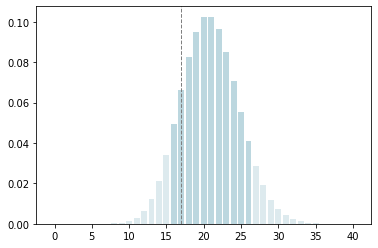

In [32]:
# defining list of r values
n=len(df_shots_player)
print(f"n={n}")
n = 40
pb = PoiBin(df_shots_player.xG)
r_values = list(range(n + 1))
# list of pmf values
dist = [pb.pmf(r) for r in r_values ]
# plotting the graph 
barlist = plt.bar(r_values, dist, color="#bcd7df")
#arlist[df_shots_player.goal.sum()].set_color('gold')
for i in range(0, np.argmax(np.cumsum(dist) >= 0.05)+1):
    barlist[i].set_alpha(.5)
for i in range(np.argmax(np.cumsum(dist) >= 0.95), n):
    barlist[i].set_alpha(.5)
plt.axvline(df_shots_player.goal.sum(), ls="--", lw = 1, color='grey')
plt.savefig(OUTPUT_DIR / "pogba-overall.pdf", transparent=True)
plt.show()

n=82


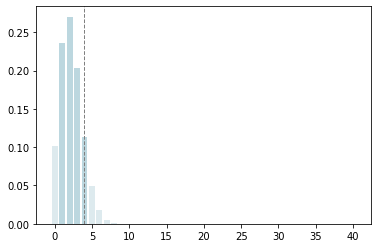

In [33]:
# defining list of r values
df = df_shots_player.loc[df_shots_player.long_distance]
n=len(df)
print(f"n={n}")
n = 40
pb = PoiBin(df.xG)
r_values = list(range(n + 1))
# list of pmf values
dist = [pb.pmf(r) for r in r_values]
# plotting the graph 
barlist = plt.bar(r_values, dist, color="#bcd7df")
#arlist[df_shots_player.goal.sum()].set_color('gold')
for i in range(0, np.argmax(np.cumsum(dist) >= 0.05)+1):
    barlist[i].set_alpha(.5)
for i in range(np.argmax(np.cumsum(dist) >= 0.95), n):
    barlist[i].set_alpha(.5)
plt.axvline(df.goal.sum(), ls="--", lw = 1, color='grey')
plt.savefig(OUTPUT_DIR / "pogba-longrange.pdf", transparent=True)
plt.show()

season=1718 / n=29


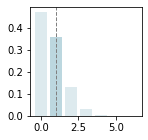

season=1819 / n=33


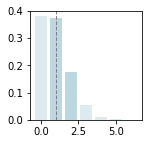

season=1920 / n=6


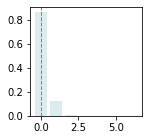

season=2021 / n=8


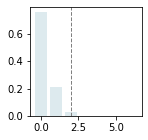

season=2122 / n=6


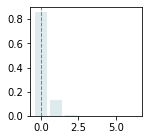

In [35]:
# defining list of r values
n=6
for season, df in df_shots_player.loc[df_shots_player.long_distance].groupby(["season"]):
    pb = PoiBin(df.xG)
    #n = int(len(df) / 4)
    print(f"season={season} / n={len(df)}")
    r_values = list(range(n + 1))
    # list of pmf values
    dist = [pb.pmf(r) for r in r_values ]
    # plotting the graph 
    plt.figure(figsize=(2,2))
    barlist = plt.bar(r_values, dist, color="#bcd7df")
    #barlist[df.goal.sum()].set_color('gold')
    for i in range(0, np.argmax(np.cumsum(dist) >= 0.05)+1):
        barlist[i].set_alpha(.5)
    for i in range(np.argmax(np.cumsum(dist) >= 0.95), n):
        barlist[i].set_alpha(.5)
    plt.axvline(df.goal.sum(), ls="--", lw = 1, color='grey')
    plt.savefig(OUTPUT_DIR / f"pogba-longrange-{season}.pdf", transparent=True)
    plt.show()

## What is the effect of deflected shots on a player's delta xG?

In [36]:
# which players have a lot of deflected shots?
df_shots_fbref.loc[df_shots_fbref.deflected].groupby('player').size().sort_values(ascending=False).head(n=10)

player
Cristiano Ronaldo    27
Alassane Pléa        19
Son Heung-min        19
Riyad Mahrez         18
Edin Džeko           18
Wilfried Zaha        17
Lionel Messi         16
Rafael Leão          16
Gonzalo Higuaín      16
Kevin De Bruyne      16
dtype: int64

In [37]:
# what is the effect of deflected shots on a players delta xg?
df_shots_player = df_shots_fbref.xs("Riyad Mahrez", level='player')
df_shots_player["Free kick"] = df_shots_player['notes'].astype(str).apply(lambda x: 'Free kick' in x)
df_shots_player = df_shots_player[~df_shots_player["Free kick"]]
df_shots_player["body_part_alt"] = df_shots_player["body_part"].copy()
df_shots_player.loc[df_shots_player["body_part_alt"] == "Left Foot", "body_part_alt"] = "Foot"
df_shots_player.loc[df_shots_player["body_part_alt"] == "Right Foot", "body_part_alt"] = "Foot"
df_shots_player['goal'] = df_shots_player["outcome"] == "Goal"
df_shots_player["long_distance"] = (df_shots_player["distance"] > 25 * 0.9144) & (df_shots_player["distance"] < 35* 0.9144)

/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-xmskill/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
print(f"Seasons included: {df_shots_player.reset_index().season.unique().tolist()}")
print(f"Number of shots: {len(df_shots_player)}")
print(f"Pct of shots deflected: {df_shots_player.deflected.sum() / len(df_shots_player):.2f}")
print(f"Goals scored: {df_shots_player.goal.sum()}")
print(f"Total xG: {df_shots_player.xG.sum()}")

Seasons included: ['1718', '1819', '1920', '2021', '2122']
Number of shots: 289
Pct of shots deflected: 0.06
Goals scored: 42
Total xG: 27.39


goals=42, xg=27.39, delta=14.61


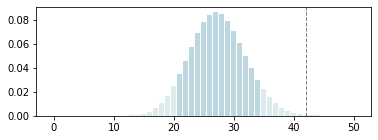

goals=35, xg=25.97, delta=9.030000000000001


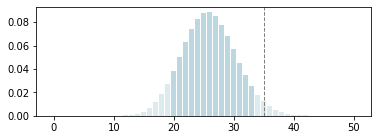

In [42]:
n=200
for name, df in zip(["with-deflections", "no-deflictions"], [df_shots_player, df_shots_player.loc[~df_shots_player.deflected]]):
    pb = PoiBin(df.xG)
    n = int(len(df) / 4)
    n = 50
    print(f"goals={df.goal.sum()}, xg={df.xG.sum()}, delta={df.goal.sum() - df.xG.sum()}")
    r_values = list(range(n + 1))
    # list of pmf values
    dist = [pb.pmf(r) for r in r_values ]
    # plotting the graph 
    plt.figure(figsize=(6,2))
    barlist = plt.bar(r_values, dist, color="#bcd7df")
    #barlist[df.goal.sum()].set_color('gold')
    for i in range(0, np.argmax(np.cumsum(dist) >= 0.05)+1):
        barlist[i].set_alpha(.5)
    for i in range(np.argmax(np.cumsum(dist) >= 0.95), n):
        barlist[i].set_alpha(.5)
    plt.axvline(df.goal.sum(), ls="--", lw = 1, color='grey')
    plt.savefig(OUTPUT_DIR / f"mahrez-{name}.pdf", transparent=True)
    plt.show()